<a href="https://colab.research.google.com/github/Frederick-Stein/Data-Science-Playground/blob/main/FashionMNIST_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
import torch
import torch.nn as nn
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import random_split, DataLoader
import torch.nn.functional as F
import pandas as pd
from torchvision import datasets, transforms
from  pathlib import Path
# from torchmetrics.classification import Accuracy
from timeit import default_timer as timer

Sample size of Train data: 60000, image: torch.Size([1, 28, 28]), label: 9
Class names: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
Device: cpu


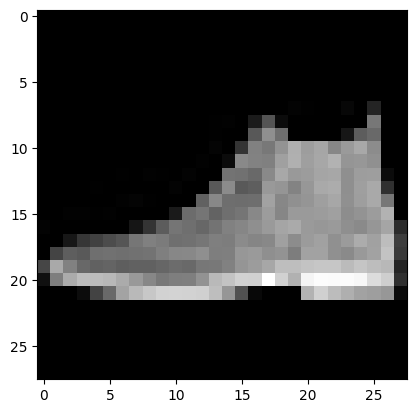

In [24]:
# 1) Datasets
generator1 = torch.Generator().manual_seed(42)
train_data = datasets.FashionMNIST(root="./data", train=True,  download=True, transform=transforms.ToTensor())
test_data = datasets.FashionMNIST(root="./data", train=False, download=True, transform=transforms.ToTensor())

image, label = next(iter(test_data))
print(f"Sample size of Train data: {len(train_data)}, image: {image.size()}, label: {label}")
plt.imshow(image.squeeze(), cmap="gray")
class_name = train_data.classes
print(f"Class names: {class_name}")

# 2) Split data
split_ratio = 0.8
train_size = int(split_ratio * len(train_data))
val_size = len(train_data) - train_size
train_data, val_data = random_split(train_data, [train_size, val_size], generator=generator1)

# 3) Set device and loader
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
pin = (device.type == 'cuda')
print(f'Device: {device}')

Batch_size = 32
train_loader = DataLoader(train_data, batch_size = Batch_size, shuffle = True, pin_memory = pin)
test_loader = DataLoader(test_data, batch_size = Batch_size, shuffle = False, pin_memory = pin)

In [25]:
## Define a timer
def train_time(start, end, device: torch.device = None):
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")

In [26]:
class ClassificationNN(nn.Module):

    def __init__(self, sizes):

        super().__init__()

        self.activiation = nn.ReLU()
        # self.activiation = nn.Sigmoid()
        # self.activiation = nn.Tanh()

        layers = [nn.Flatten()]
        for i in range(len(sizes) - 1):
            layers.append(nn.Linear(sizes[i], sizes[i+1]))
            if i != len(sizes) - 2:
                layers.append(self.activiation)
        self.layer_stack = nn.Sequential(*layers)

    def forward(self, x):
        return self.layer_stack(x)

In [27]:
# test
X_0, y_0 = next(iter(train_loader))
print(X_0.shape, y_0)
device
model = ClassificationNN([784, 30, 10]).to(device)
X_0= X_0.to(device)
model(X_0)

torch.Size([32, 1, 28, 28]) tensor([5, 3, 6, 2, 3, 0, 8, 0, 2, 0, 9, 5, 5, 7, 9, 3, 6, 2, 5, 6, 4, 2, 0, 7,
        5, 8, 6, 6, 0, 4, 7, 8])


tensor([[ 0.1280, -0.0040,  0.1821,  0.0379, -0.0589,  0.0057,  0.0718,  0.0477,
         -0.0996,  0.1487],
        [ 0.1623, -0.0805,  0.1171, -0.0235, -0.0423, -0.1067,  0.0029,  0.1163,
         -0.0851,  0.0804],
        [ 0.1704,  0.0641,  0.1941, -0.1544, -0.0475, -0.1595, -0.2132,  0.2356,
         -0.1331,  0.1568],
        [ 0.2423,  0.1914,  0.1634, -0.2174, -0.0184, -0.0431, -0.2249,  0.2590,
         -0.0403,  0.2992],
        [ 0.2230,  0.0325,  0.1823, -0.1641, -0.0131, -0.1442, -0.1238,  0.1421,
         -0.0567,  0.0516],
        [ 0.1482,  0.0950,  0.1288, -0.1070,  0.0013, -0.1161, -0.1234,  0.1480,
         -0.0017,  0.0916],
        [ 0.2952,  0.1015,  0.1306, -0.1977, -0.1234, -0.0584, -0.0750,  0.0550,
         -0.1378,  0.3582],
        [ 0.1691,  0.2052,  0.0938, -0.0490,  0.0198, -0.0832, -0.1456,  0.1380,
         -0.0319,  0.1209],
        [ 0.1814, -0.0163,  0.1142, -0.0172, -0.0677, -0.0840,  0.0088,  0.0219,
         -0.0618,  0.0808],
        [ 0.1671, -

In [28]:
## Move the model to the device
model = ClassificationNN([784, 30, 10, len(class_name)]).to(device)

## Loss function
loss_fcn = nn.CrossEntropyLoss()

## Optimization method
# optimizer = optim.SGD(model.parameters(), lr = 0.1, momentum = 0.9)
optimizer = optim.Adam(model.parameters(), lr = 0.001, weight_decay= 1e-4)


## Metric setup
# accuracy_metric = Accuracy(task="multiclass", num_classes=10).to(device)

epochs = 10
train_error = []
test_error = []
train_accuracy = []
test_accuracy = []
epoch_range = []

train_time_start = timer()

for epoch in range(1, epochs+1):

    model.train()
    train_loss = 0
    correct_train = 0
    # accuracy_metric.reset()

    for X_batch, y_batch in train_loader:

        # Move data to device
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        # Feedforward
        y_pred = model(X_batch)

        # Compute loss
        loss = loss_fcn(y_pred, y_batch)

        # Initialize optimizer
        optimizer.zero_grad()

        # Back-propogation
        loss.backward()

        # Gradient descent
        optimizer.step()

        train_loss += loss.detach().item() * X_batch.size(0)
        predicted = y_pred.argmax(dim=1)
        correct_train += (predicted == y_batch).sum().item()
        # accuracy_metric.update(predicted, y_batch)

    train_loss /= len(train_data)
    train_acc = correct_train / len(train_data) * 100 # train accuracy
    # train_acc = accuracy_metric.compute().item() * 100

    model.eval()
    with torch.inference_mode():
        correct_test = 0 # accuracy
        test_loss = 0
        # accuracy_metric.reset()


        for X_batch, y_batch in test_loader:
            # Move data to device
            X_batch = X_batch.to(device, non_blocking=True)
            y_batch = y_batch.to(device, non_blocking=True)

            # Training process
            y_pred = model(X_batch)

            loss = loss_fcn(y_pred, y_batch)
            test_loss += loss.item() * X_batch.size(0)

            # Calculate accuracy
            predicted = y_pred.argmax(dim=1)
            correct_test += (predicted == y_batch).sum().item()
            # accuracy_metric.update(predicted, y_batch)

        test_loss /= len(test_data)
        test_acc = correct_test / len(test_data) * 100
        # test_acc = accuracy_metric.compute().item() * 100

        train_error.append(train_loss)
        test_error.append(test_loss)
        train_accuracy.append(train_acc)
        test_accuracy.append(test_acc)
        epoch_range.append(epoch)

        if epoch % 5 == 0:
            print(f"Epoch: {epoch} | Train loss: {train_loss: .4f} | Test loss: {test_loss: .4f} | Test accuracy: {test_acc:.2f}%")

train_time_end = timer()
train_time(train_time_start, train_time_end, device)

Epoch: 5 | Train loss:  0.3938 | Test loss:  0.4480 | Test accuracy: 84.31%
Epoch: 10 | Train loss:  0.3442 | Test loss:  0.4216 | Test accuracy: 85.14%
Train time on cpu: 116.931 seconds


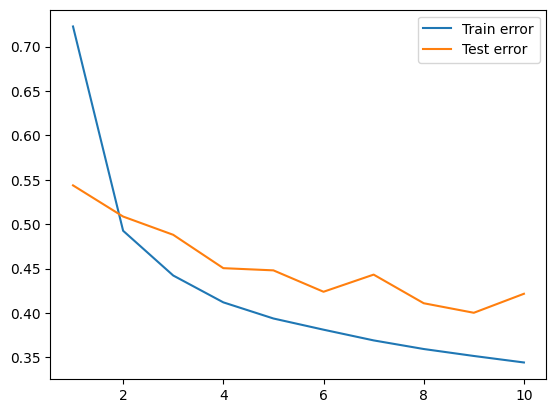

In [29]:
# Plot error
plt.plot(epoch_range, train_error, label = "Train error")
plt.plot(epoch_range, test_error, label = "Test error")
plt.legend()

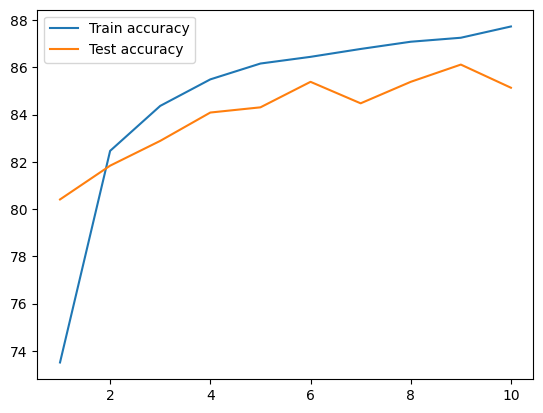

In [30]:
# Plot accuracy
plt.plot(epoch_range, train_accuracy, label = "Train accuracy")
plt.plot(epoch_range, test_accuracy, label = "Test accuracy")
plt.legend()